# Tutorial on a U Net on the Brain MRI segmentation task

In [1]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
use_colab = False
if use_colab:
    from google.colab import drive
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    os.chdir('/content/drive/MyDrive/Medium articles/0001 - UNet')
    os.getcwd()


In [3]:
# Path to all data
DATA_PATH = "archive/lgg-mri-segmentation/kaggle_3m/"


# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [4]:
from pathlib import Path

# Initialize a list to store directory and path info
data_map = []

# Get all subdirectories
sub_dirs = [x for x in Path(DATA_PATH).iterdir() if x.is_dir()]

# Iterate over subdirectories
for sub_dir in sub_dirs:
    # Get all files in subdirectory
    files = [x for x in sub_dir.iterdir() if x.is_file()]

    # Extend data_map with dirname and path info
    data_map.extend([[str(sub_dir.name), str(file)] for file in files])

# Create DataFrame
df = pd.DataFrame(data_map, columns=["dirname", "path"])


In [5]:
df.head()

,dirname,path
0,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
1,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
2,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
3,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
4,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...


In [6]:
df['path'].str.contains("mask").value_counts()

True     3929
False    3929
Name: path, dtype: int64

In [7]:
# We create 2 dataframes that contain the paths to the images and masks respectively

# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]) if x[BASE_LEN:-END_IMG_LEN].isdigit() else 0)
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]) if x[BASE_LEN:-END_MASK_LEN].isdigit() else 0)


# Sanity check
print(len(imgs), len(masks))


3929 3929


In [8]:
df_imgs

,dirname,path
5,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
8,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
9,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
12,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
13,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
...,...,...
7845,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...
7852,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...
7853,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...
7854,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...


In [9]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})




In [11]:
# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
1,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
2,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
3,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
4,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
...,...,...,...,...
3924,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0
3925,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0
3926,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0
3927,TCGA_FG_A60K_20040224,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0


In [ ]:
# If the cell above takes too long, you can load the dataframe from the csv file
# read csv
df = pd.read_csv("data.csv", index_col=0)

In [12]:
sample_tumor_index = df[df["diagnosis"] == 1].sample(1).index
sample_sane_index = df[df["diagnosis"] == 0].sample(1).index

tumor_image_path = df.iloc[sample_tumor_index]["image_path"].values[0]
sane_image_path = df.iloc[sample_sane_index]["image_path"].values[0]
tumor_mask_path = df.iloc[sample_tumor_index]["mask_path"].values[0]
sane_mask_path = df.iloc[sample_sane_index]["mask_path"].values[0]

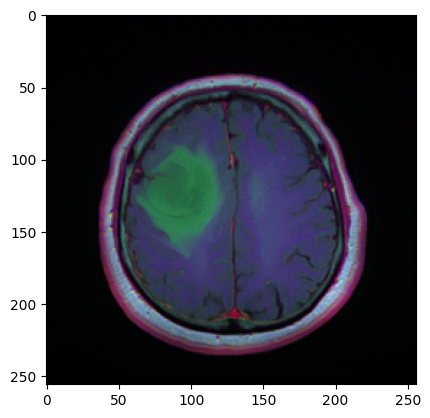

In [13]:
plt.imshow(cv2.imread(tumor_image_path))

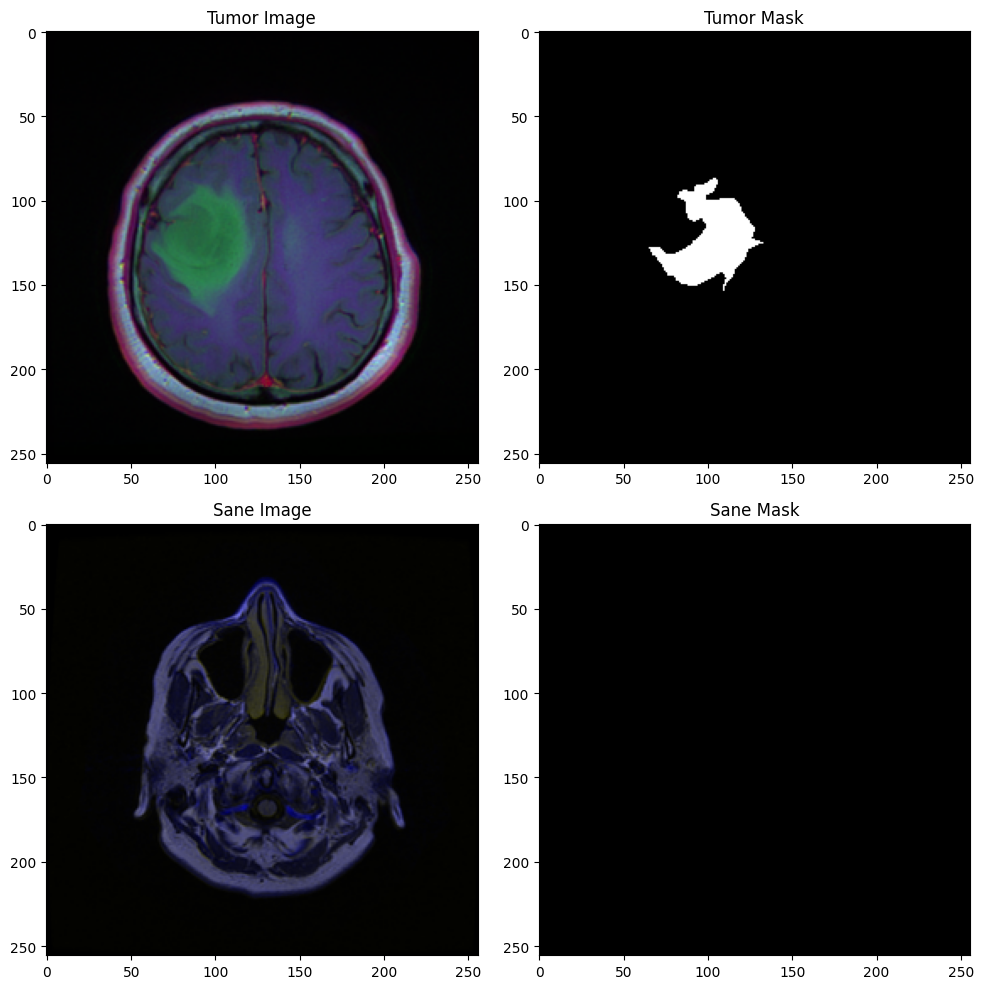

In [14]:
import matplotlib.pyplot as plt
import cv2

# Define the image paths
paths = [tumor_image_path, tumor_mask_path, sane_image_path, sane_mask_path]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over each subplot
for i, ax in enumerate(axs.flat):
    # Read the image
    img = cv2.imread(paths[i])

    # Convert the image from BGR to RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    ax.imshow(img)

    # Set the title
    if i == 0:
        ax.set_title('Tumor Image')
    elif i == 1:
        ax.set_title('Tumor Mask')
    elif i == 2:
        ax.set_title('Sane Image')
    else:
        ax.set_title('Sane Mask')

# Display the plot
plt.tight_layout()
plt.show()


# DataGenerator class

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/unet/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/envs/unet/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /opt/anaconda3/envs/unet/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <DAEF2BE1-BBB4-3005-8003-63A504CDB9D9> /opt/anaconda3/envs/unet/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [17]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        # df contains the paths to all files
        self.df = df
        # transforms is the set of data augmentation operations we use
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image,
                                    mask=mask)

        image = augmented['image'] # Dimension (3, 255, 255)
        mask = augmented['mask']   # Dimension (255, 255)

        # We notice that the image has one more dimension (3 color channels), so we have to one one "artificial" dimension to the mask to match it
        mask = np.expand_dims(mask, axis=0) # Dimension (1, 255, 255)

        return image, mask


In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

PATCH_SIZE = 128 # or 256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Emboss(p=0.25),  # replaced A.IAAEmboss with A.Emboss
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),

    A.Normalize(p=1.0),
    ToTensorV2(),
])

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensorV2(),
])


In [19]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [20]:
train_dataset = BrainMriDataset(train_df, transforms)
image, mask = train_dataset[0]  # get the first item
print(image.shape, mask.shape)
print(image, mask)

torch.Size([3, 128, 128]) (1, 128, 128)
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.0323, -2.0837, -2.1179],
         [-2.0837, -2.0665, -2.0494,  ..., -2.0494, -2.0837, -2.1179],
         [-2.0494, -2.0665, -2.0323,  ..., -2.0323, -2.0665, -2.1179],
         ...,
         [-2.1179, -2.1008, -2.0323,  ..., -2.0494, -2.0837, -2.0837],
         [-2.1179, -2.1008, -2.0494,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.9482, -2.0007, -2.0357],
         [-2.0007, -1.9832, -1.9657,  ..., -1.9657, -2.0007, -2.0357],
         [-1.9657, -1.9832, -1.9482,  ..., -1.9482, -1.9832, -2.0357],
         ...,
         [-2.0357, -2.0182, -1.9482,  ..., -1.9657, -2.0007, -2.0007],
         [-2.0357, -2.0182, -1.9657,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
     

# Creation of the datasets

In [21]:
train_dataset = BrainMriDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = BrainMriDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = BrainMriDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Get a batch of training data
images, masks = next(iter(train_dataloader))

print(f'Images batch shape: {images.shape}')
print(f'Masks batch shape: {masks.shape}')

# Optionally, visualize an image and mask from this batch
import matplotlib.pyplot as plt

# Assuming the images are in the PyTorch format (batch_size, channels, height, width)
# and they are single channel (grayscale), you can use the following


Images batch shape: torch.Size([32, 3, 128, 128])
Masks batch shape: torch.Size([32, 1, 128, 128])


# Model!!!

In [23]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [24]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Define convolutional layers
        # These are used in the "down" path of the U-Net,
        # where the image is successively downsampled
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)

        # Define max pooling layer for downsampling
        self.maxpool = nn.MaxPool2d(2)

        # Define upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Define convolutional layers
        # These are used in the "up" path of the U-Net,
        # where the image is successively upsampled
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)

        # Define final convolution to output correct number of classes
        # 1 because there are only two classes (tumor or not tumor)
        self.last_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through the network

        # Down path
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)

        # Up path
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv_up1(x)

        # Final output
        out = self.last_conv(x)
        out = torch.sigmoid(out)

        return out


In [25]:
unet = UNet().to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


In [26]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [27]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    inputs = inputs.float()
    target = target.float()

    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]),
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Train U Net


In [28]:
from tqdm import tqdm

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):

    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        # We store the training loss and dice scores
        losses = []
        train_iou = []

        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

        # Add tqdm to the loop (to visualize progress)
        for i_step, (data, target) in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}")):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())

            # If the score is less than a threshold (0.5), the prediction is 0, otherwise its 1
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            # Reset the gradients
            optimizer.zero_grad()
            # Perform backpropagation to compute gradients
            loss.backward()
            # Update the parameters with the computed gradients
            optimizer.step()

            if lr_scheduler:
                lr_scheduler.step()

        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

    return loss_history, train_history, val_history



def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)

            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step


In [29]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)

In [30]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [84]:
%%time
num_ep = 20
# Train UNet
unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_epochs = 20)

Vanila_UNet


Training epoch 1/20: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch [0]
Mean loss on train: -159.98968637433458 
Mean DICE on train: 1.3902428098318182 
Mean DICE on validation: 1.538762860762571


Training epoch 2/20: 100%|██████████| 94/94 [00:33<00:00,  2.81it/s]


Epoch [1]
Mean loss on train: -163.99557811655896 
Mean DICE on train: 1.412415486205528 
Mean DICE on validation: 1.5357395357801422


Training epoch 3/20: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch [2]
Mean loss on train: -163.58311260887916 
Mean DICE on train: 1.4211828917860985 
Mean DICE on validation: 1.5389016918569505


Training epoch 4/20: 100%|██████████| 94/94 [00:32<00:00,  2.94it/s]


Epoch [3]
Mean loss on train: -164.6006585942938 
Mean DICE on train: 1.4116162224994377 
Mean DICE on validation: 1.5369010657725928


Training epoch 5/20: 100%|██████████| 94/94 [00:32<00:00,  2.92it/s]


Epoch [4]
Mean loss on train: -164.1520080033769 
Mean DICE on train: 1.409086951968856 
Mean DICE on validation: 1.5382202490882468


Training epoch 6/20: 100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch [5]
Mean loss on train: -164.16052646839873 
Mean DICE on train: 1.4218154631895328 
Mean DICE on validation: 1.5377887168176


Training epoch 7/20: 100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch [6]
Mean loss on train: -163.87335752933583 
Mean DICE on train: 1.4133392912476332 
Mean DICE on validation: 1.5374779802958674


Training epoch 8/20: 100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch [7]
Mean loss on train: -164.0552757445802 
Mean DICE on train: 1.4132157302995592 
Mean DICE on validation: 1.539269174284762


Training epoch 9/20: 100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch [8]
Mean loss on train: -163.7756442922227 
Mean DICE on train: 1.4200023054227775 
Mean DICE on validation: 1.534940830732667


Training epoch 10/20: 100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch [9]
Mean loss on train: -163.886758416257 
Mean DICE on train: 1.4106997459163368 
Mean DICE on validation: 1.5387309835879257


Training epoch 11/20: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch [10]
Mean loss on train: -164.31504459330375 
Mean DICE on train: 1.4177741070263041 
Mean DICE on validation: 1.5381032205619103


Training epoch 12/20: 100%|██████████| 94/94 [00:34<00:00,  2.74it/s]


Epoch [11]
Mean loss on train: -164.24226028361218 
Mean DICE on train: 1.4196567190182992 
Mean DICE on validation: 1.5377802549494446


Training epoch 13/20: 100%|██████████| 94/94 [00:32<00:00,  2.88it/s]


Epoch [12]
Mean loss on train: -164.5133474836958 
Mean DICE on train: 1.413122792973926 
Mean DICE on validation: 1.5395922623326015


Training epoch 14/20: 100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch [13]
Mean loss on train: -164.23362823242837 
Mean DICE on train: 1.4021927703689456 
Mean DICE on validation: 1.5380668557918729


Training epoch 15/20: 100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch [14]
Mean loss on train: -163.99217746612874 
Mean DICE on train: 1.411978655073153 
Mean DICE on validation: 1.5384595004279336


Training epoch 16/20: 100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch [15]
Mean loss on train: -163.7769203744036 
Mean DICE on train: 1.4155516433523487 
Mean DICE on validation: 1.5379911527459813


Training epoch 17/20: 100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch [16]
Mean loss on train: -163.8585653913782 
Mean DICE on train: 1.4167295186966642 
Mean DICE on validation: 1.537151488231017


Training epoch 18/20: 100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch [17]
Mean loss on train: -163.59545080712502 
Mean DICE on train: 1.4157315937409556 
Mean DICE on validation: 1.539446278410823


Training epoch 19/20: 100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch [18]
Mean loss on train: -164.30804826350922 
Mean DICE on train: 1.415646023217764 
Mean DICE on validation: 1.5388628670700006


Training epoch 20/20: 100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch [19]
Mean loss on train: -163.95206906186775 
Mean DICE on train: 1.4153120489070028 
Mean DICE on validation: 1.5392714313634641
CPU times: user 6min 55s, sys: 37.2 s, total: 7min 32s
Wall time: 11min 52s


# Saving the model

In [31]:
os.getcwd()

'/Users/francoisporcher/Downloads/unet'

In [91]:
# Assuming you have a trained model object named 'model'
# Specify the path where you want to save the model
model_path = os.getcwd()
model_path = os.path.join(model_path, 'unet.pth')  # Use the desired file extension, e.g., 'unet.pth'

# Export and save the model
torch.save(unet.state_dict(), model_path)


# Load the model

In [33]:
# Instantiate the model class
unet = UNet().to(device)

# Load the model parameters
unet.load_state_dict(torch.load("unet.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

# Visualize predictions

In [35]:
def generate_random_indices(dataset, num_samples):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    return indices[:num_samples]


torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


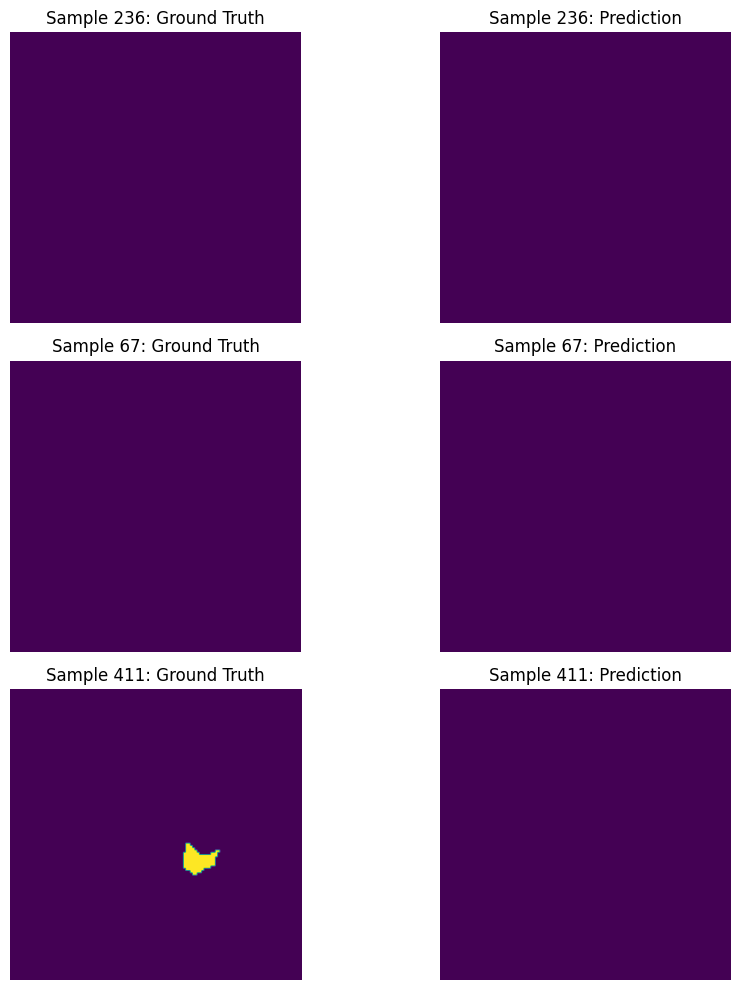

In [65]:
import matplotlib.pyplot as plt

# Generate random sample indices from the test set
num_samples = 3
sample_indices = generate_random_indices(test_dataset, num_samples)

# Create a subplot with the input images and predictions
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i, idx in enumerate(sample_indices):
    image, mask = test_dataset[idx]
    mask = mask[0, :, :]
    prediction = unet(image.unsqueeze(0).to(device))
    print(prediction.shape)
    prediction = prediction[0, 0, :, :].data.cpu().numpy()
    
    # Plot the input image
    axes[i, 0].imshow(mask)
    axes[i, 0].set_title(f"Sample {idx}: Ground Truth")
    
    # Plot the prediction
    axes[i, 1].imshow(prediction)
    axes[i, 1].set_title(f"Sample {idx}: Prediction")
    
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()